# Opening TEMPO Level-2 data usign the new `open_virtual_dataset` functionality in `earthaccess`

## Summary

In this tutorial, we will use the `earthaccess.open_virtual_mfdataset()` function to open multiple granules in the data collection for the [TEMPO air quality mission (link)](https://asdc.larc.nasa.gov/project/TEMPO). We will then extract a subset of the data for visualization.

## Prerequisites

This tutorial has been designed to run in an AWS cloud compute instance in AWS region us-west-2. However, if you want to run it from your laptop or workstation, everything should work just fine but without the speed benefits of in-cloud access.

An Earthdata Login account is required to access data from the NASA Earthdata system. Before requesting TEMPO data, we first need to set up our Earthdata Login authentication, as described in the Earthdata Cookbook's [earthaccess tutorial (link)](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html).

## Setup

In [1]:
import earthaccess
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
auth = earthaccess.login()

if not auth.authenticated:
    auth.login(
        strategy="interactive", persist=True
    )  # ask for credentials and persist them in a .netrc file

## Get granule links

We search for TEMPO Nitrogen Dioxide ($NO_2$) data for a two-hour period (note: times are in UTC) from January, 2024.

In [15]:
results = earthaccess.search_data(
    short_name="TEMPO_NO2_L2",
    version="V03",
    # temporal=("2024-01-11 12:00", "2024-01-11 16:00"),
    count=20,
)
print(f"Number of granules in result: {len(results)}")

Number of granules in result: 20


## Open Virtual Multifile Datasets

Because TEMPO data are processed and archived in a netCDF4 format using a group hierarchy, we want to open all of the groups.

### First, we open the root group for all granules

In [19]:
def preprocess_root_group(ds: xr.Dataset) -> xr.Dataset:
    # Add scan number and granule number as new dimensions
    return ds.expand_dims(["scan_num"]).assign_coords(scan_num=[ds.attrs["scan_num"]])


open_options = {
    "access": "indirect",
    "load": True,
    "preprocess": preprocess_root_group,
    "concat_dim": "scan_num",
    "coords": "all",
    "compat": "override",
    "combine_attrs": "drop_conflicts",
    "parallel": False,
}

result_root = earthaccess.open_virtual_mfdataset(granules=results, **open_options)

### Take the new `coords` from the root group, and apply it to the subgroups

In [20]:
root_group_scan_num_coords = result_root.coords["scan_num"]

# Define a modified preprocessing function for subgroups
# When iterating over datasets, a 'global' allows extracting the corresponding coords' value
global my_scan_counter


def add_scan_num_coords(ds: xr.Dataset) -> xr.Dataset:
    global my_scan_counter

    this_ds_scan_num = root_group_scan_num_coords.values[my_scan_counter]
    my_scan_counter += 1

    # Add scan number and granule number as dimensions
    return ds.expand_dims(["scan_num"]).assign_coords(scan_num=[this_ds_scan_num])


open_options["preprocess"] = add_scan_num_coords

# Open the subgroups
my_scan_counter = 0
result_product = earthaccess.open_virtual_mfdataset(
    granules=results, group="product", **open_options
)

my_scan_counter = 0
result_geolocation = earthaccess.open_virtual_mfdataset(
    granules=results, group="geolocation", **open_options
)

# --- 3. MERGE ROOT GROUPS WITH SUBGROUPS ---
result_merged = xr.merge([result_root, result_product, result_geolocation])

### Merge root groups with subgroups

In [21]:
result_merged = xr.merge([result_root, result_product, result_geolocation])

In [22]:
result_merged["vertical_column_stratosphere"]

<xarray.DataArray 'vertical_column_stratosphere' (scan_num: 20,
                                                  mirror_step: 123, xtrack: 2048)> Size: 40MB
dask.array<open_dataset-vertical_column_stratosphere, shape=(20, 123, 2048), dtype=float64, chunksize=(1, 123, 2048), chunktype=numpy.ndarray>
Coordinates:
  * mirror_step  (mirror_step) float64 984B nan 1.0 2.0 ... 120.0 121.0 122.0
  * scan_num     (scan_num) float64 160B 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
  * xtrack       (xtrack) float64 16kB nan 1.0 2.0 ... 2.046e+03 2.047e+03
    latitude     (scan_num, mirror_step, xtrack) float32 20MB dask.array<chunksize=(1, 123, 2048), meta=np.ndarray>
    longitude    (scan_num, mirror_step, xtrack) float32 20MB dask.array<chunksize=(1, 123, 2048), meta=np.ndarray>
    time         (scan_num, mirror_step) datetime64[ns] 20kB dask.array<chunksize=(1, 123), meta=np.ndarray>
Attributes:
    long_name:  stratosphere nitrogen dioxide vertical column
    units:      molecules/cm^2

## Visualize part of the opened datasets

In [30]:
z_variable = result_merged["vertical_column_stratosphere"]

x = result_merged["longitude"].where(result_merged["scan_num"] == 1)
y = result_merged["latitude"].where(result_merged["scan_num"] == 1)
z = z_variable.where(result_merged["scan_num"] == 1)

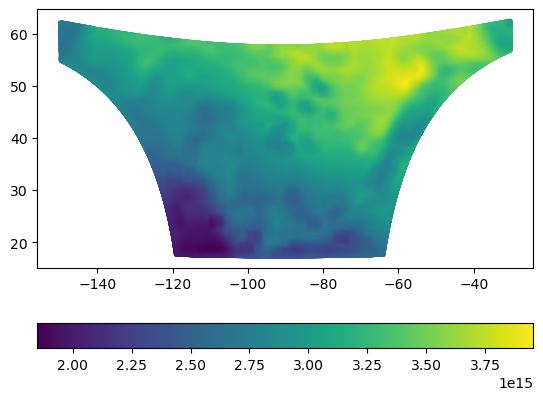

In [36]:
fig, ax = plt.subplots()
scatter_handle = ax.scatter(x=x, y=y, s=5, c=z)

clb = fig.colorbar(scatter_handle, orientation="horizontal")
clb.ax.set_label(f"{z_variable.attrs['long_name']}\n({z_variable.attrs['units']})")

plt.show()

In [ ]:
### Opening a single granule
# open_options = {
#     "access": "indirect",
#     "load": True,
# }

# result_root = earthaccess.open_virtual_dataset(results[0], **open_options)
# result_product = earthaccess.open_virtual_dataset(results[0], group="product", **open_options)
# result_geolocation = earthaccess.open_virtual_dataset(results[0], group="geolocation", **open_options)

# result_merged = xr.merge([result_root, result_product, result_geolocation])
# result_merged

In [ ]:
### As is, with mirror_step
# open_options = {
#     "access": "indirect",
#     "load": True,
#     "concat_dim": "mirror_step",
#     "coords": 'minimal',
#     "compat": 'override',
#     "parallel": False,
#     "preprocess": None,
# }

# result_root = earthaccess.open_virtual_mfdataset(granules=results, **open_options)
# result_product = earthaccess.open_virtual_mfdataset(granules=results, group="product", **open_options)
# result_geolocation = earthaccess.open_virtual_mfdataset(granules=results, group="geolocation", **open_options)

# result_merged = xr.merge([result_root, result_product, result_geolocation])
# result_merged